In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
from scipy.stats import randint as sp_randint
import pickle

# Using K-Means with PCA + LDA

In [2]:
from keras.datasets import cifar10 

2024-04-19 16:45:47.462568: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 16:45:47.462708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 16:45:47.622009: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


[6]
<class 'numpy.ndarray'>


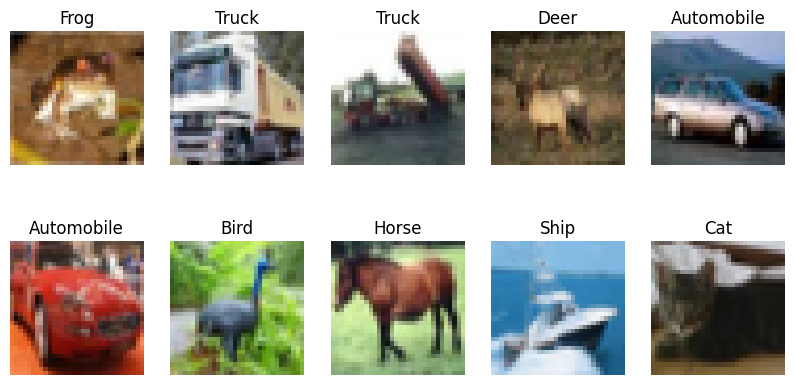

In [4]:
class_names = {
    0: 'Airplane',
    1: 'Automobile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck'
}
print(y_train[0])
print(type(y_train[0]))
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()
for i in range(10):
    axes[i].imshow(X_train[i])
    class_index = int(y_train[i].item())  # Convert NumPy array to integer
    class_name = class_names[class_index]
    axes[i].set_title(class_name)
    axes[i].set_title(class_name)
    axes[i].axis('off')
plt.show()

In [5]:
scaler = StandardScaler()

#Flatten images
x_train_flattened = X_train.reshape(X_train.shape[0], -1)
print(x_train_flattened.shape)
x_train = scaler.fit_transform(x_train_flattened)

(50000, 3072)


## Using PCA

In [6]:
# Compute covariance matrix
cov_matrix = np.cov(x_train_flattened, rowvar=False)

#Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

#Sort and take highest eigenvalues and their corresponding eigenvectors
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]
print(idx)

[   0    1    2 ... 2381 2380 2379]


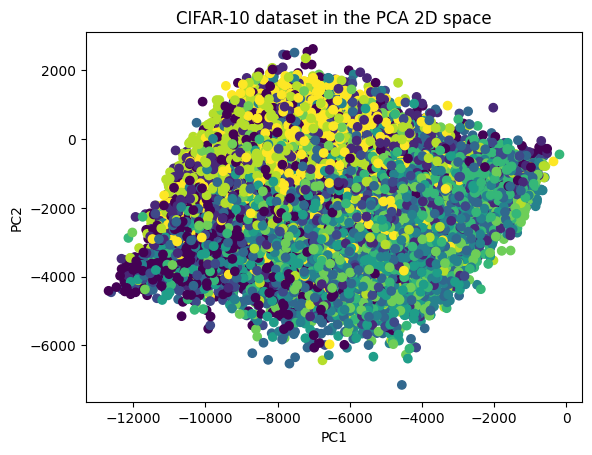

In [7]:
k = 50
top_k_eigenvectors = eigenvectors[:, :k]

#Projecting the data into smaller space
x_train_pca = x_train_flattened.dot(top_k_eigenvectors)

plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('CIFAR-10 dataset in the PCA 2D space')
plt.show()

## Using LDA

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

print(X_train.shape)
print(x_train.shape)
x_trainl = X_train.reshape(X_train.shape[0], 32*32*3)
x_testl = X_test.reshape(X_test.shape[0], 32*32*3)
print(x_train.shape)
x_trainl = x_trainl.astype('float32')
x_testl = x_testl.astype('float32')
x_trainl /= 255
x_testl /= 255

# # create a LDA object
lda = LinearDiscriminantAnalysis(n_components=3)
y_train= y_train.ravel()
y_test= y_test.ravel()
# # fit the LDA on the training set
lda.fit(x_trainl, y_train)

# transform the training and test sets
x_train_lda = lda.transform(x_trainl)
x_test_lda = lda.transform(x_testl)

(50000, 32, 32, 3)
(50000, 3072)
(50000, 3072)


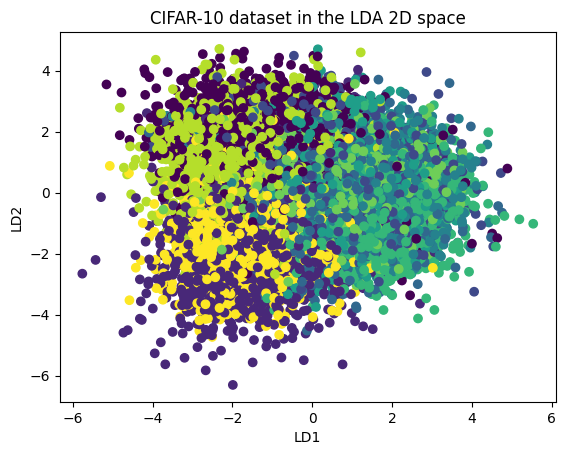

In [9]:
import matplotlib.pyplot as plt

# Plot the training set
plt.scatter(x_train_lda[:, 0], x_train_lda[:, 1], c=y_train)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('CIFAR-10 dataset in the LDA 2D space')
plt.show()

## K-Means with LDA

In [10]:
from sklearn.cluster import KMeans

#LDA
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(x_train_lda)
y_predLDA = kmeans.predict(x_train_lda)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


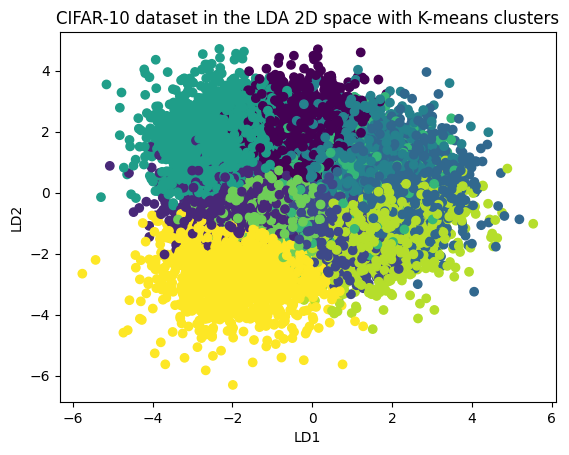

In [11]:
plt.scatter(x_train_lda[:, 0], x_train_lda[:, 1], c=y_predLDA)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('CIFAR-10 dataset in the LDA 2D space with K-means clusters')
plt.show()

## K-Means with PCA

In [12]:
#PCA
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(x_train_pca)
y_predPCA = kmeans.predict(x_train_pca)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


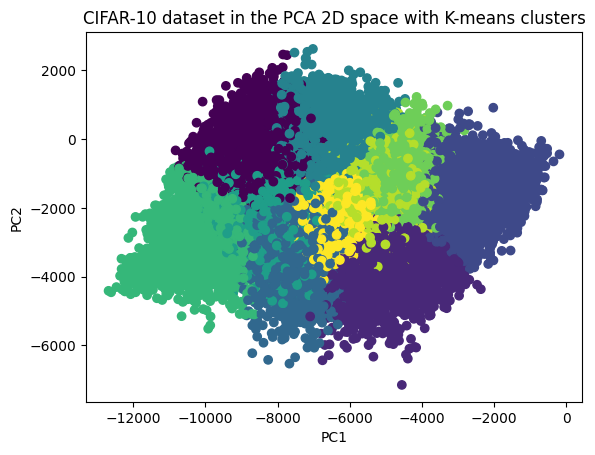

In [13]:
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_predPCA)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('CIFAR-10 dataset in the PCA 2D space with K-means clusters')
plt.show()

## Using a new dimensionality reduction technique: t-SNE (t-distributed Stochastic Neighbor Embedding)

In [14]:
from sklearn.manifold import TSNE

In [15]:
X = X_train.reshape(X_train.shape[0], -1)
y = y_train.reshape(-1)

# Apply t-SNE


In [16]:
tsne = TSNE(n_components=2, perplexity=30)
X_tsne = tsne.fit_transform(X)

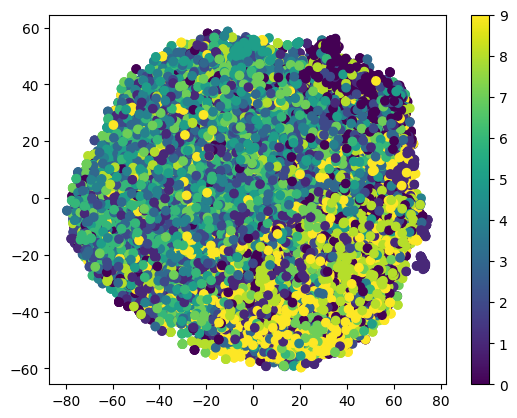

In [17]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.colorbar()
plt.show()

## Now K-Means + t-SNE

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


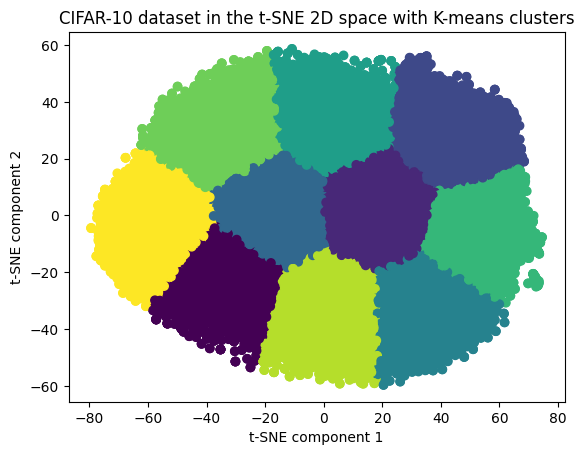

In [18]:

kmeanss= KMeans(n_clusters=10, random_state=0)

# fit the KMeans on the t-SNE transformed data
kmeanss.fit(X_tsne)

# predict the cluster labels
y_predX_tsne = kmeanss.predict(X_tsne)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_predX_tsne)
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.title('CIFAR-10 dataset in the t-SNE 2D space with K-means clusters')
plt.show()